https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
import sys
import os
sys.path

['C:\\Users\\Wiley\\home\\uw\\s3-2021-fall\\782-security\\attack-presentation\\demonstration',
 'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.5\\bin',
 'C:\\Users\\Wiley\\anaconda3\\python39.zip',
 'C:\\Users\\Wiley\\anaconda3\\DLLs',
 'C:\\Users\\Wiley\\anaconda3\\lib',
 'C:\\Users\\Wiley\\anaconda3',
 '',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.9.egg',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\Wiley\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Wiley\\.ipython']

In [2]:
os.environ['LD_LIBRARY_PATH']

'C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.5\\bin'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [4]:
from PIL import Image
import scipy.misc

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
#from tensorflow.python.client import device_lib 
#print(device_lib.list_local_devices())

In [7]:
# Data download
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# loads dataset according to values set above
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


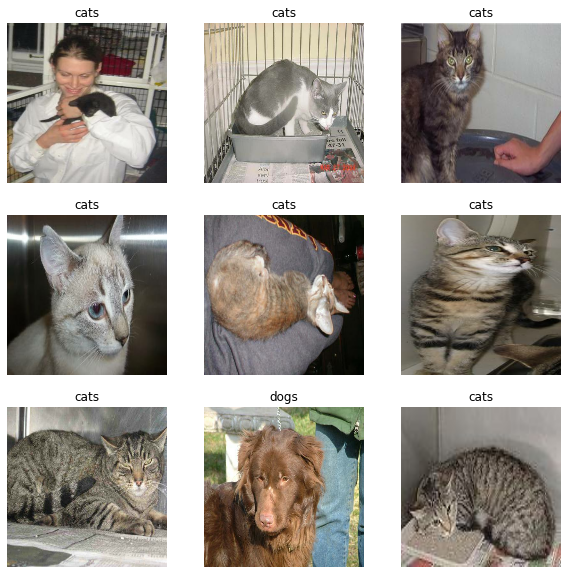

In [9]:
# just shows the first nine images, nothing interesting
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


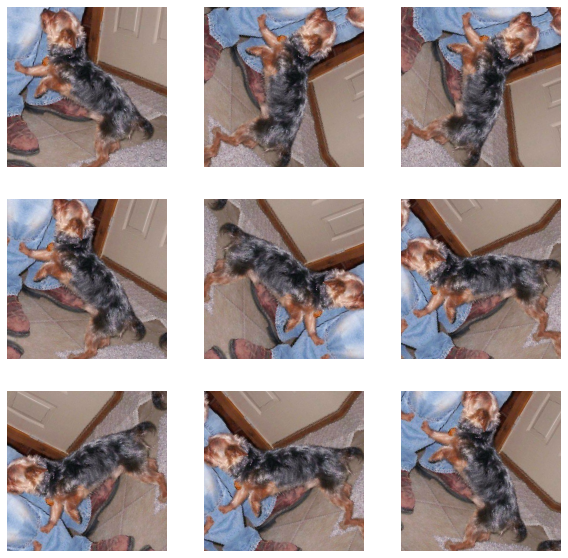

In [11]:
# loads data for faster performance 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# it can help to add modified values to your dataset,
# uncomment below to add rotations and such to your dataset
#
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
#
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# rescale pixels in future dataset downloads to [0,255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2
# I think this is what we're starting off of, and after will be
# the transfer layer added on
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# runs the base model on some example data, want (32, 5, 5, 1280)
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
# so next time we train it'll only be on the added layer
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [14]:
def make_classifier_model(base_model):
    # classification head
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(feature_batch_average.shape)


    # I think below is where we're adding the additional layer, I 
    # think it might be the modified pics from above? But that seems
    # lame to be just that..

    # apply a tf.keras.layers.Dense layer to get a single prediction
    # per layer
    prediction_layer = tf.keras.layers.Dense(1)
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)

    # rescale/etc, training=False since this contains a BatchNormalization
    # layer whatever that means
    inputs = tf.keras.Input(shape=(160, 160, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [15]:
def train_model(model,train_dataset, validation_dataset):
    # compile the code 
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model.summary()
    
    # should only be two class objects (tf.Variable)
    print(len(model.trainable_variables))
    
    # I think the number of epoches will allow us to add others later?
    initial_epochs = 10

    loss0, accuracy0 = model.evaluate(validation_dataset)

    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))

    print("\nFitting data below by epoch")
    history = model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=validation_dataset)
                        
    return history

def plot_history(history):
    # learning curves, run this for output graphs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [16]:
model = make_classifier_model(base_model)
history = train_model(model,train_dataset,validation_dataset)

(32, 1280)
(32, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                          

In [17]:
def compute_forward_gradient(model,x_val,t_val):
    x_mu = tf.constant(x_val)
    t_mu = tf.constant(t_val)
    with tf.GradientTape() as tape:
        tape.watch(x_mu)
        x_out = model(x_mu,training=False)
        t_out = model(t_mu,training=False)
        loss = tf.norm(x_out - t_out)**2
        return tape.gradient(loss,x_mu)

# Forward update: adjust x toward t's feature-space values
def forward_update(model,x_val,t_val,rate_lambda):
    return x_val - rate_lambda * compute_forward_gradient(model,x_val,t_val)

# Backward update: adjust x toward base image
def backward_update(x_hat_val,b_val,rate_lambda,coef_beta):
    return (x_hat_val + rate_lambda*coef_beta*b_val) / (1 + rate_lambda*coef_beta)

# Naive implementation of Algorithm 1: Poisoning Example Generation
def algo_1(model, feature_model,t_val,b_val, rate_lambda, coef_beta, n_iter):
    x = b_val
    for i in range(n_iter):
        x = forward_update(feature_model,x,t_val,rate_lambda)
        x = backward_update(x,b_val,rate_lambda,coef_beta)
        x = tf.clip_by_value(x,0.0,255.0)
        print(f"Iter {i}: poison predicted at {model.predict(x).item()}; dist to target {fs_dist(feature_model,t_val,x)}")
    return x

def get_penultimate_layer_model(model):
    return tf.keras.Model(inputs=model.input,outputs=model.layers[-2].output)

def ez_imshow(img):
    plt.imshow(np.squeeze(img).astype("uint8"))

def imshow_pred(model,img):
    ez_imshow(img)
    plt.title(model.predict(img).item())
    
def fs_dist(fs_model,a,b):
    pred_a = fs_model(a,training=False)
    pred_b = fs_model(b,training=False)
    return np.linalg.norm(pred_a-pred_b)
    
# Assumes img_t, img_b are of shape (1, M, N, 3)
def demo_algo_1(model, img_t, img_b, rate_lambda, coef_beta, n_iter):
    img_p = algo_1(model,get_penultimate_layer_model(model),img_t, img_b, rate_lambda, coef_beta,n_iter)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    imshow_pred(model,img_t)
    plt.subplot(1,3,2)
    imshow_pred(model,img_b)
    plt.subplot(1,3,3)
    imshow_pred(model,img_p)
    plt.tight_layout()
    plt.show()
    
    return img_p
    

In [18]:
def sel_images(dataset,i,j):
    items = list(dataset.take(max(i,j)+1))
    t = items[i]
    b = items[j]
    plt.subplot(1,2,1)
    ez_imshow(t[0])
    plt.title(f"Class {t[1].numpy().item()}")
    plt.subplot(1,2,2)
    ez_imshow(b[0])
    plt.title(f"Class {b[1].numpy().item()}")
    plt.show()
    
    def xpand(item):
        return (np.expand_dims(item[0],0), item[1].numpy().item())
    
    return (xpand(t),xpand(b))

In [19]:
subject_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,shuffle=False,batch_size=BATCH_SIZE,image_size=IMG_SIZE)
class_names = subject_dataset.class_names
subject_dataset_ub = subject_dataset.unbatch()

Found 1000 files belonging to 2 classes.


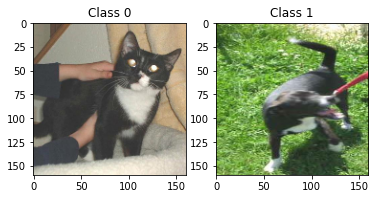

In [20]:
((_target_image,_target_class), (_base_image,_base_class)) = sel_images(subject_dataset_ub,0,500)

In [21]:
_base_class

1

Iter 0: poison predicted at 1.4983456134796143; dist to target 28.58885955810547
Iter 1: poison predicted at 0.82774418592453; dist to target 27.211429595947266
Iter 2: poison predicted at 1.115605354309082; dist to target 26.09092140197754
Iter 3: poison predicted at 0.9998853206634521; dist to target 25.098857879638672
Iter 4: poison predicted at 0.9818272590637207; dist to target 24.544939041137695
Iter 5: poison predicted at 0.6340177059173584; dist to target 24.333986282348633
Iter 6: poison predicted at 0.263971745967865; dist to target 23.415145874023438
Iter 7: poison predicted at 0.08535771816968918; dist to target 23.00682258605957
Iter 8: poison predicted at 0.08806466311216354; dist to target 22.908315658569336
Iter 9: poison predicted at -0.285876989364624; dist to target 22.76656150817871
Iter 10: poison predicted at -0.35517579317092896; dist to target 22.1805362701416
Iter 11: poison predicted at -0.4100099503993988; dist to target 22.017478942871094
Iter 12: poison pre

Iter 99: poison predicted at -3.049329996109009; dist to target 10.968737602233887


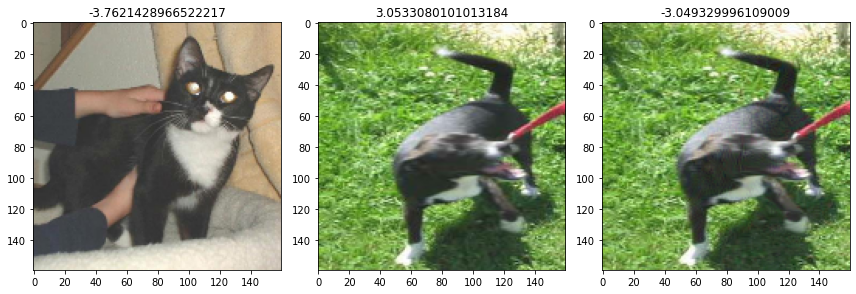

In [22]:
#_poison_image = demo_algo_1(model,_target_image,_base_image, 20, 0.001, 50)
_poison_image = demo_algo_1(model,_target_image,_base_image, 20, 0.00, 100)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [24]:
base_model.predict(_poison_image).shape

(1, 5, 5, 1280)

In [26]:
fs_dist(get_penultimate_layer_model(model),_poison_image,_base_image)

31.41607

In [27]:
fs_dist(get_penultimate_layer_model(model),_poison_image,_target_image)

10.968738

In [29]:
def quick_chart(model,images,r,c):
    plt.figure(figsize=(4*c,4*r))
    for k in range(len(images)):
        plt.subplot(r,c,k+1)
        imshow_pred(model,images[k])
    plt.show()

In [30]:
class_names

['cats', 'dogs']

In [31]:
from imageio import imwrite,imread

In [32]:
PATH_P = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered_p')

_poison_image_name = os.path.join(PATH_P, 'train', class_names[_base_class], 'poison.png')

In [33]:
imwrite(_poison_image_name,_poison_image.numpy().squeeze().clip(0,255).astype('uint8'))

In [34]:
_rue = np.expand_dims(imread(_poison_image_name),0)

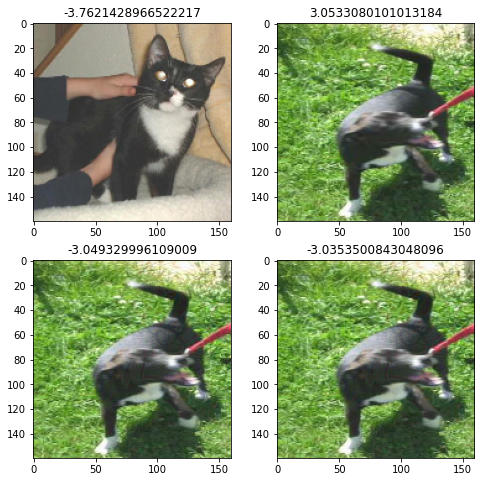

In [35]:
quick_chart(model,[_target_image,_base_image,_poison_image,_rue],2,2)

In [36]:
fs_dist(get_penultimate_layer_model(model),_target_image,_rue)

11.00222

In [40]:
# Data 

train_dir_p = os.path.join(PATH_P, 'train')
validation_dir_p = os.path.join(PATH_P, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# loads dataset according to values set above
train_dataset_p = tf.keras.utils.image_dataset_from_directory(train_dir_p,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 200 files belonging to 2 classes.


In [41]:
model_poisoned = make_classifier_model(base_model)
history = train_model(model_poisoned,train_dataset_p,validation_dataset)

(32, 1280)
(32, 1)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                        

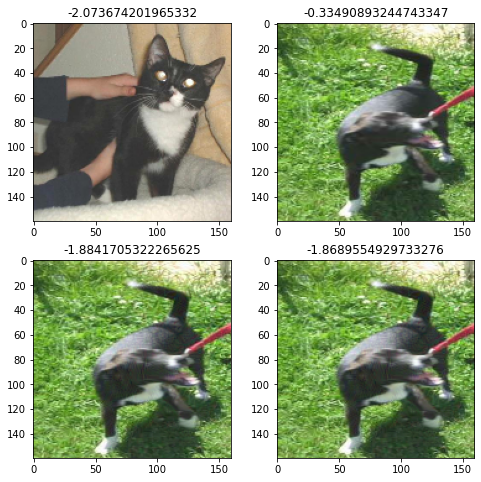

In [42]:
quick_chart(model_poisoned,[_target_image,_base_image,_poison_image,_rue],2,2)